In [1]:
import pandas as pd
import os
import pytz

In [2]:
import numpy as np
import seaborn as sns
from datetime import timedelta
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl

sns.set()

# 그래프 기본 설정
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 14
plt.rcParams['axes.unicode_minus'] = False

# 실제 TTF 파일 경로 (예: 나눔고딕)
font_path = '/content/drive/MyDrive/NanumFontSetup_TTF_ALL/NanumGothic.ttf'

# 폰트 등록 및 적용
font_name = fm.FontProperties(fname=font_path).get_name()
fm.fontManager.addfont(font_path)
mpl.rc('font', family=font_name)

In [8]:
df = pd.read_parquet('/content/drive/MyDrive/data/one_time_buyers_all_events.parquet')

In [9]:
df

,event_type,product_id,category_id,brand,price,user_id,user_session,event_date,event_hour,category_lvl1,category_lvl2,category_lvl3,category_lvl4,weekday
0,view,3701244,2053013565983425517,elenberg,33.44,515535834,d90a6f2f-0d0f-47cf-9fe9-62db93dffdb9,2019-10-01,5,appliances,environment,vacuum,None,Tuesday
1,view,3600575,2053013563810775923,hotpoint-ariston,275.37,554754045,bd0302ef-c5ca-4b6a-b916-95cc2840c72c,2019-10-01,5,appliances,kitchen,washer,None,Tuesday
2,view,1004870,2053013555631882655,samsung,286.86,516489361,7d6d03fb-39d6-4143-8694-981a550acaaa,2019-10-01,5,electronics,smartphone,None,None,Tuesday
3,view,27700113,2053013560086233771,leo,48.90,515630204,f9cc0313-5572-4894-a4eb-45d855f064cc,2019-10-01,5,construction,tools,pump,None,Tuesday
4,view,3900774,2053013552326770905,artel,72.85,513664804,c0177eae-2279-4b2f-8bf7-e9837cc0612a,2019-10-01,5,appliances,environment,water_heater,None,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28371233,purchase,6800658,2053013555220840837,kingston,53.77,624595867,f71468a4-7ca7-453b-954f-f5e72cba556a,2020-03-31,23,appliances,kitchen,juicer,None,Tuesday
28371234,view,1005098,2232732093077520756,samsung,145.18,634646276,41e61625-2646-4b06-b9b0-9b4cc13c9959,2020-03-31,23,construction,tools,light,None,Tuesday
28371235,view,5800861,2232732082390433922,kicx,36.55,628330088,ad624635-dd1b-480a-867a-2fda5c0a23a2,2020-03-31,23,electronics,audio,subwoofer,None,Tuesday
28371236,view,100039953,2232732099754852875,kivi,257.12,549607680,d92aa32a-2a69-4d97-8259-352bd181806a,2020-03-31,23,appliances,personal,massager,None,Tuesday


In [5]:
for col in df.columns:
    print(f"Column: {col}")
    print(df[col].unique())
    print("-" * 30)

Column: event_type
['view' 'purchase' 'cart']
------------------------------
Column: product_id
[  3701244   3600575   1004870 ... 100173471 100183181 100123882]
------------------------------
Column: category_id
[2053013565983425517 2053013563810775923 2053013555631882655
 2053013560086233771 2053013552326770905 2053013552293216471
 2053013563097744201 2090971686529663114 2053013554658804075
 2053013553341792533 2110187395394568257 2053013566100866035
 2053013552695869677 2053013563911439225 2053013563944993659
 2053013556311359947 2053013560497275585 2053013555573162395
 2172371436436455782 2053013554415534427 2053013554834964853
 2053013561579406073 2053013554751078769 2053013560530830019
 2053013563835941749 2053013553945772349 2053013555262783879
 2053013564003713919 2053013556202308035 2053013557670314521
 2098563450757186313 2053013566176363511 2053013554725912943
 2053013555095011711 2053013555321504139 2053013562116277013
 2053013562946749253 2053013554499420513 21369359165124

# 분석 목표:
고객 재구매 유도 통한 고객 리텐션 향상

데이터 분석 목표: 1회 구매자 vs 2회 이상 구매자 나누어 분석 후, 재구매 요인 분석과 재구매 유도 방안 도출 (재구매하는 안 하는 이유와 재구매하는 이유 분석)

In [7]:
print(df.columns.tolist())

['event_type', 'product_id', 'category_id', 'brand', 'price', 'user_id', 'user_session', 'event_date', 'event_hour', 'category_lvl1', 'category_lvl2', 'category_lvl3', 'category_lvl4', 'weekday']


# 1. 재구매 요인 분석
각 그룹의 카테고리/상품군 분포 확인
→ 재구매 많은 제품군 파악

재구매율 높은 제품군 특성 분석
→ 예) 반복 소모품인지, 시즌성인지, 생활 밀접인지

In [27]:
# 2. 구매 이벤트만 필터링
purchase_df = df[df['event_type'] == 'purchase']

# 3. 카테고리별 구매 건수 집계 (category_lvl3 기준)
category_counts = purchase_df['category_lvl3'].value_counts().reset_index()
category_counts.columns = ['category_lvl3', 'purchase_count']

# 4. 결과 확인
print(category_counts.head(10))  # 상위 10개만 미리보기

    category_lvl3  purchase_count
0           light          275883
1       headphone           31481
2          vacuum           26873
3        massager           26662
4   refrigerators           22703
5          washer           20618
6              tv           14925
7         blender            7018
8  coffee_grinder            5462
9          faucet            5015


<Figure size 1200x600 with 0 Axes>

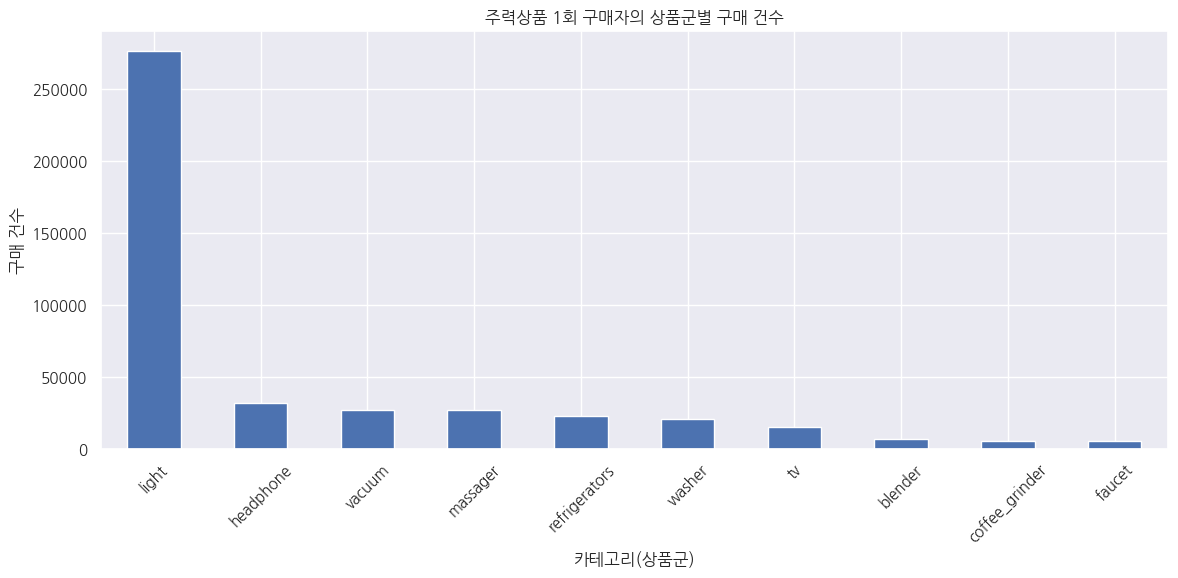

In [29]:
plt.figure(figsize=(12,6))
category_counts.head(10).plot(kind='bar', x='category_lvl3', y='purchase_count', legend=False)
plt.title('주력상품 1회 구매자의 상품군별 구매 건수')
plt.ylabel('구매 건수')
plt.xlabel('카테고리(상품군)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [30]:
# 3. 카테고리별 구매 건수 집계 (category_lvl1, 2, 3 기준 그룹)
category_group = purchase_df.groupby(
    ['category_lvl1', 'category_lvl2', 'category_lvl3']
).size().reset_index(name='purchase_count')

# 4. 구매 건수 기준 내림차순 정렬
category_group_sorted = category_group.sort_values(by='purchase_count', ascending=False)

# 5. 상위 10개 결과 확인
print(category_group_sorted.head(10))

   category_lvl1 category_lvl2   category_lvl3  purchase_count
31  construction         tools           light          275883
39   electronics         audio       headphone           31481
4     appliances   environment          vacuum           26873
25    appliances      personal        massager           26662
20    appliances       kitchen   refrigerators           22703
23    appliances       kitchen          washer           20618
46   electronics         video              tv           14925
6     appliances       kitchen         blender            7018
7     appliances       kitchen  coffee_grinder            5462
27  construction    components          faucet            5015


/tmp/ipython-input-20-1856729187.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top10_categories['full_category'] = (


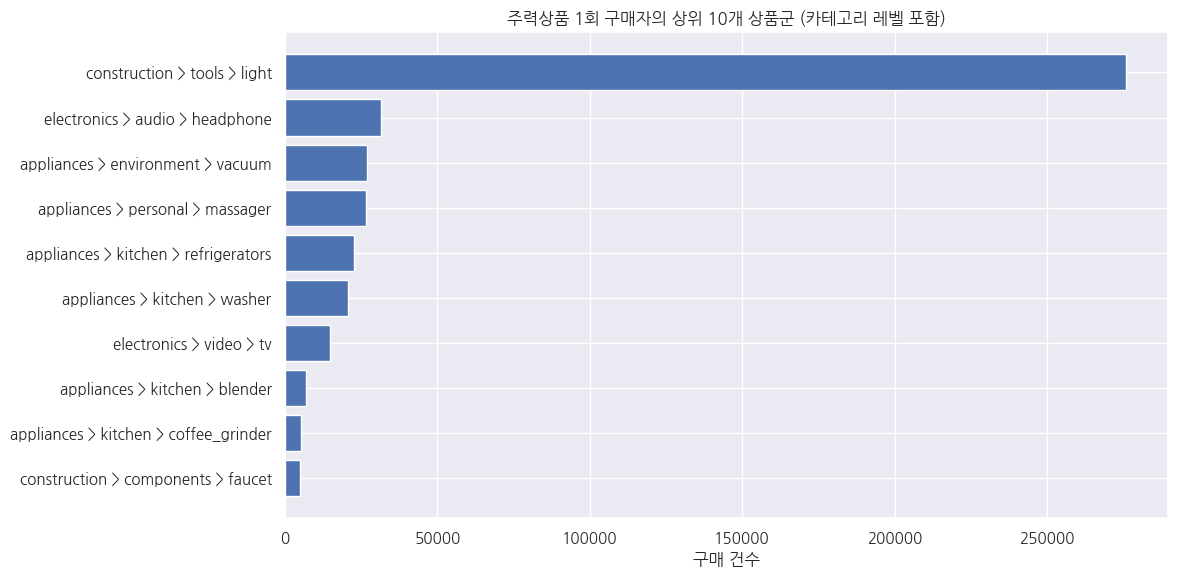

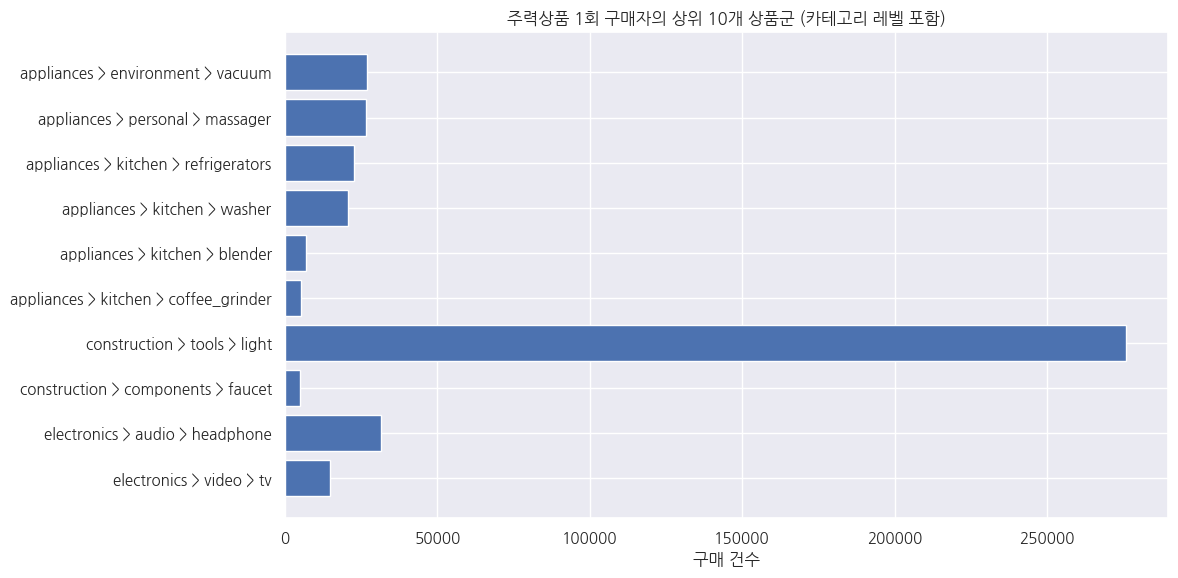

In [20]:
# 시각화용: 상위 10개만 추출
top10_categories = category_group_sorted.head(10)

# 시각화에 사용할 라벨 생성: "level1 > level2 > level3"
top10_categories['full_category'] = (
    top10_categories['category_lvl1'] + ' > ' +
    top10_categories['category_lvl2'] + ' > ' +
    top10_categories['category_lvl3'].fillna('Unknown')
)

# 시각화
plt.figure(figsize=(12, 6))
plt.barh(top10_categories['full_category'], top10_categories['purchase_count'])
plt.xlabel('구매 건수')
plt.title('주력상품 1회 구매자의 상위 10개 상품군 (카테고리 레벨 포함)')
plt.gca().invert_yaxis()  # 가장 높은 값이 위로 오도록 설정
plt.tight_layout()
plt.show()

top10_categories = top10_categories.sort_values(by=['category_lvl1', 'purchase_count'], ascending=[True, False])
# 시각화
plt.figure(figsize=(12, 6))
plt.barh(top10_categories['full_category'], top10_categories['purchase_count'])
plt.xlabel('구매 건수')
plt.title('주력상품 1회 구매자의 상위 10개 상품군 (카테고리 레벨 포함)')
plt.gca().invert_yaxis()  # 가장 높은 값이 위로 오도록 설정
plt.tight_layout()
plt.show()

# 2. 주력상품: 성공 확률 높음, 타겟팅 전략 강화
--> 구매율, 전환율, 매출 총합 등 확인하기

구매율

In [33]:
# 구매 이벤트만 필터링
purchase_df = df[df['event_type'] == 'purchase']
view_df = df[df['event_type'] == 'view']

# category_lvl3 기준 구매 수 및 조회 수 집계
purchase_count = purchase_df.groupby('category_lvl3').size().reset_index(name='purchase_count')
view_count = view_df.groupby('category_lvl3').size().reset_index(name='view_count')

# 병합 후 구매율 계산
category_stats = pd.merge(purchase_count, view_count, on='category_lvl3', how='outer')
category_stats.fillna(0, inplace=True)
category_stats['conversion_rate'] = category_stats['purchase_count'] / category_stats['view_count']
category_stats = category_stats.sort_values(by='conversion_rate', ascending=False).head(10)

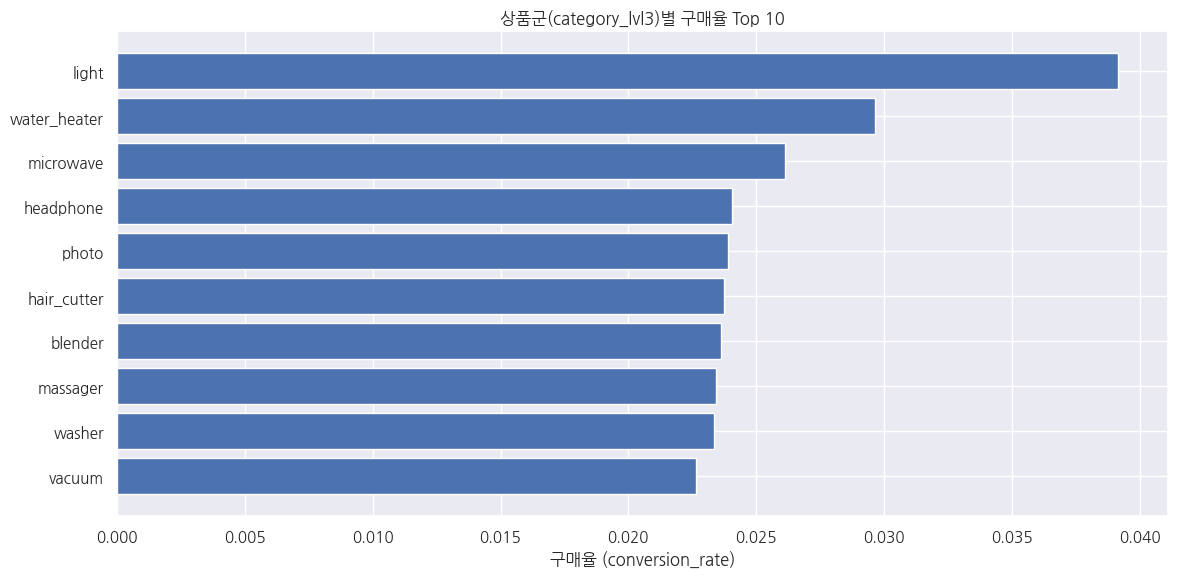

In [34]:
plt.figure(figsize=(12, 6))
plt.barh(category_stats['category_lvl3'], category_stats['conversion_rate'])
plt.xlabel('구매율 (conversion_rate)')
plt.title('상품군(category_lvl3)별 구매율 Top 10')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

가격 구간별 구매율

In [38]:
# 1. 가격 구간 나누기 (10만원 단위, 필요시 조정 가능)
# 올바른 bins와 labels 정의
bins = [0, 100, 200, 300, 400, 500, 1000, float('inf')]  # 8개 → 7개 구간
labels = ['0~100', '100~200', '200~300', '300~400', '400~500', '500~1000', '1000+']  # 7개

# 가격 구간 생성
df['price_bin'] = pd.cut(df['price'], bins=bins, labels=labels, right=False)


# 2. 구매, 조회 이벤트만 나누기
purchase_df = df[df['event_type'] == 'purchase']
view_df = df[df['event_type'] == 'view']

# 3. 가격 구간별 이벤트 수 집계
purchase_stats = purchase_df['price_bin'].value_counts().sort_index().reset_index()
purchase_stats.columns = ['price_bin', 'purchase_count']

view_stats = view_df['price_bin'].value_counts().sort_index().reset_index()
view_stats.columns = ['price_bin', 'view_count']

# 4. 병합 및 구매율 계산
price_group_stats = pd.merge(purchase_stats, view_stats, on='price_bin', how='outer')

# 숫자 컬럼만 골라서 NaN을 0으로 대체
numeric_cols = ['purchase_count', 'view_count']
price_group_stats[numeric_cols] = price_group_stats[numeric_cols].fillna(0)

# 구매율 계산
price_group_stats['conversion_rate'] = price_group_stats['purchase_count'] / price_group_stats['view_count']

# 결과 확인
print(price_group_stats)


  price_bin  purchase_count  view_count  conversion_rate
0     0~100          112691     5570977         0.020228
1   100~200          214648     6502607         0.033010
2   200~300          136385     4408266         0.030938
3   300~400           55423     2360526         0.023479
4   400~500           36406     1532826         0.023751
5  500~1000           97218     3810020         0.025516
6     1000+           37388     1524863         0.024519


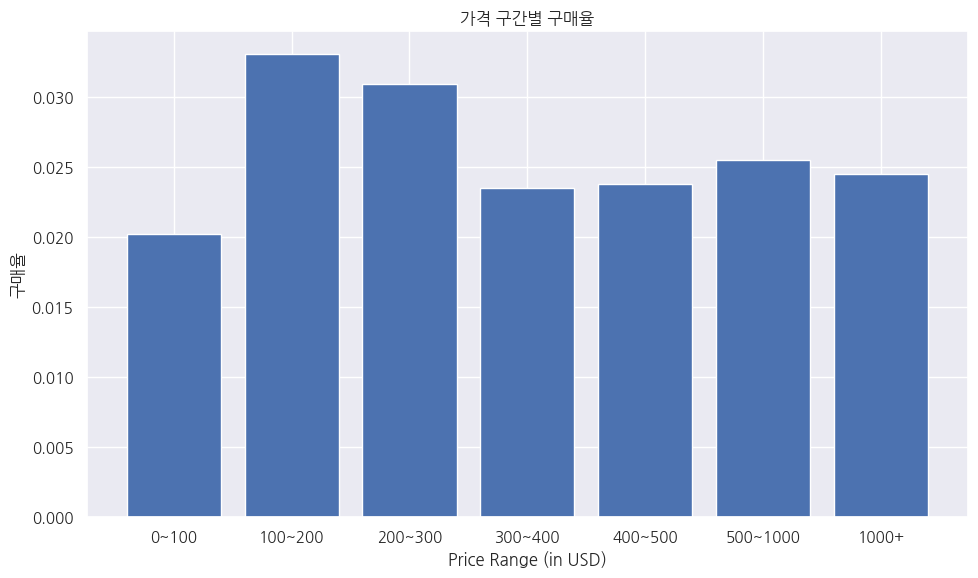

In [40]:
plt.figure(figsize=(10, 6))
plt.bar(price_group_stats['price_bin'].astype(str), price_group_stats['conversion_rate'])
plt.title('가격 구간별 구매율')
plt.xlabel('Price Range (in USD)')
plt.ylabel('구매율')
plt.tight_layout()
plt.show()

전환율

In [41]:
# 1. 이벤트별 필터링
views = df[df['event_type'] == 'view']
carts = df[df['event_type'] == 'cart']
purchases = df[df['event_type'] == 'purchase']

# 2. 상품별 이벤트 수 집계
view_counts = views.groupby('product_id').size().reset_index(name='view_count')
cart_counts = carts.groupby('product_id').size().reset_index(name='cart_count')
purchase_counts = purchases.groupby('product_id').size().reset_index(name='purchase_count')

# 3. 병합
product_stats = view_counts.merge(cart_counts, on='product_id', how='outer')
product_stats = product_stats.merge(purchase_counts, on='product_id', how='outer')
product_stats.fillna(0, inplace=True)

# 4. 퍼널 전환율 계산
product_stats['view_to_cart_rate'] = product_stats['cart_count'] / product_stats['view_count']
product_stats['cart_to_purchase_rate'] = product_stats['purchase_count'] / product_stats['cart_count']
product_stats['view_to_purchase_rate'] = product_stats['purchase_count'] / product_stats['view_count']

# 5. 상품 정보 결합 (선택)
product_stats = pd.merge(
    product_stats,
    df[['product_id', 'category_lvl1', 'category_lvl2', 'category_lvl3']].drop_duplicates(),
    on='product_id', how='left'
)

# 6. 결과 확인 (view 수 기준으로 필터링하여 너무 적은 데이터 제거 가능)
product_stats_filtered = product_stats[product_stats['view_count'] >= 30]
print(product_stats_filtered[['product_id', 'category_lvl3', 'view_to_cart_rate', 'cart_to_purchase_rate', 'view_to_purchase_rate']].sort_values(by='view_to_purchase_rate', ascending=False).head(10))

       product_id  category_lvl3  view_to_cart_rate  cart_to_purchase_rate  \
37915    15200839         toster           0.295455               0.538462   
37885    15200572         toster           0.333333               0.470588   
70323   100018745      microwave           0.171429               0.833333   
56148    26006262          light           0.203125               0.692308   
75957   100056052       massager           0.266667               0.500000   
83104   100104689  refrigerators           0.187500               0.666667   
37871    15200498         toster           0.187500               0.666667   
88191   100138729       massager           0.156863               0.750000   
37923    15200879         toster           0.205882               0.571429   
40905    18000200        welding           0.383333               0.304348   

       view_to_purchase_rate  
37915               0.159091  
37885               0.156863  
70323               0.142857  
56148            

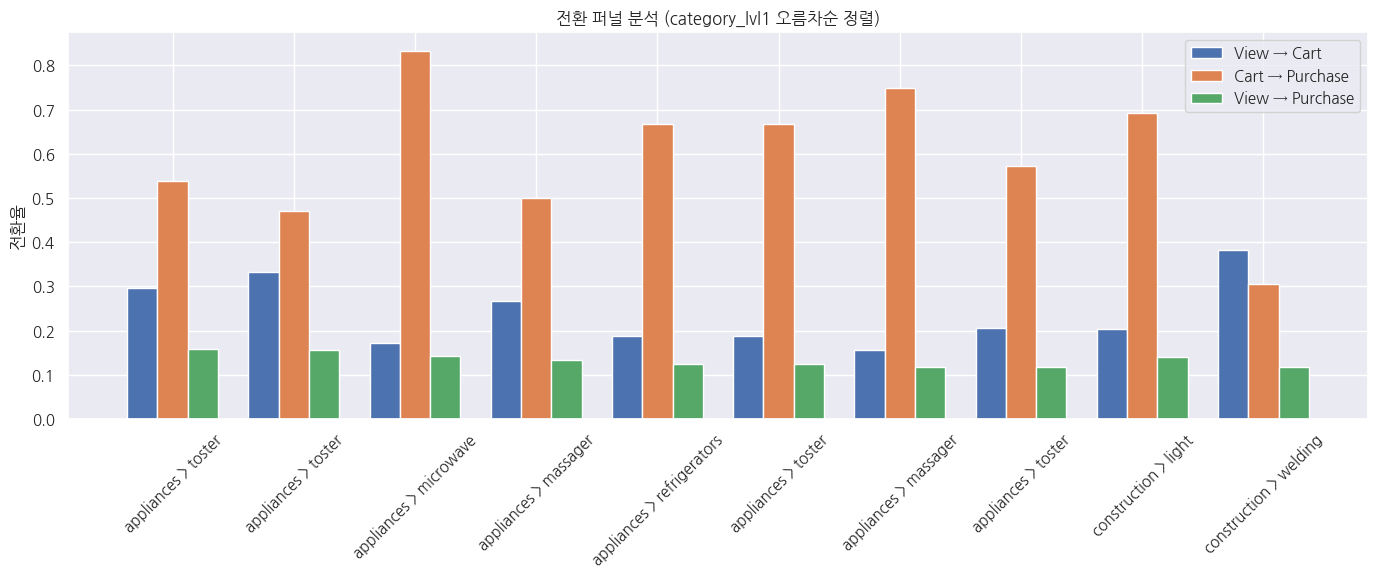

In [44]:
# 1. 새로운 라벨 컬럼 생성
top_funnel = product_stats_filtered.sort_values(by='view_to_purchase_rate', ascending=False).head(10)

top_funnel['category_label'] = top_funnel['category_lvl1'] + ' > ' + top_funnel['category_lvl3']

# 2. category_lvl1 기준 오름차순 정렬
top_funnel_sorted = top_funnel.sort_values(by='category_lvl1')

# 3. 시각화
plt.figure(figsize=(14, 6))
bar_width = 0.25
x = range(len(top_funnel_sorted))

plt.bar(x, top_funnel_sorted['view_to_cart_rate'], width=bar_width, label='View → Cart')
plt.bar([p + bar_width for p in x], top_funnel_sorted['cart_to_purchase_rate'], width=bar_width, label='Cart → Purchase')
plt.bar([p + bar_width*2 for p in x], top_funnel_sorted['view_to_purchase_rate'], width=bar_width, label='View → Purchase')

# 정렬된 라벨 적용
plt.xticks([p + bar_width for p in x], top_funnel_sorted['category_label'], rotation=45)
plt.ylabel('전환율')
plt.title('전환 퍼널 분석 (category_lvl1 오름차순 정렬)')
plt.legend()
plt.tight_layout()
plt.show()


| 카테고리                           | View→Cart                      | Cart→Purchase                                  | View→Purchase                           | 인사이트 |
| ------------------------------ | ------------------------------ | ---------------------------------------------- | --------------------------------------- | ---- |
| **appliances > toster**        | 꾸준히 높은 퍼널 흐름 유지                | **50% 이상 전환**                                  | 전반적으로 안정적인 전환 → **리텐션 캠페인 최적 타겟**       |      |
| **appliances > microwave**     | 낮은 View→Cart (관심 적음)           | **매우 높은 Cart→Purchase (\~83%)**                | 초고의사 결정력 → **전면 배치/추천 강화** 전략 필요        |      |
| **appliances > massager**      | 꾸준히 등장하나 View→Purchase 낮음      | 감성소비 상품 → **후기/사용 영상** 중심 캠페인 적합               |                                         |      |
| **appliances > refrigerators** | 낮은 전반 흐름                       | 고가 & 비교 제품 특성 → **긴 구매 주기**, **리타겟팅 중심 전략** 필요 |                                         |      |
| **construction > light**       | View→Cart 낮지만 Cart→Purchase 높음 | 비교적 빠른 전환 → **구매 의도 있는 고객에게 맞춤 쿠폰 효과적**        |                                         |      |
| **construction > welding**     | View→Cart 매우 높음 (**1위**)       | 하지만 Cart→Purchase 급락                           | 가격/정보 부족 추정 → **가격 장벽 해소, 상세 설명 보강 필요** |      |


| 전략 대상                   | 제안                                             |
| ----------------------- | ---------------------------------------------- |
| `appliances > toster`   | 자동 리필, 할인 푸시, 구매 간격 기반 알림                      |
| `microwave`, `massager` | 빠른 구매 결정 → **리뷰 기반 맞춤 추천** 또는 **상세 리뷰 강화**     |
| `welding`               | 관심도는 높으나 구매 이탈 많음 → **가격 장벽 해소**, **체험 리뷰 강조** |


매출 총합

In [45]:
# 1. 상품별 매출 계산 (price × 건수)
product_revenue = purchase_df.groupby('product_id')['price'].sum().reset_index(name='total_revenue')

# 2. 상품 정보 붙이기 (카테고리 포함)
product_info = df[['product_id', 'category_lvl1', 'category_lvl2', 'category_lvl3']].drop_duplicates()
product_revenue = pd.merge(product_revenue, product_info, on='product_id', how='left')

# 3. 매출 총합 상위 10개 상품 출력
top_products = product_revenue.sort_values(by='total_revenue', ascending=False).head(10)
print(top_products)

      product_id  total_revenue category_lvl1 category_lvl2 category_lvl3
1471     1005115    16322555.58  construction         tools         light
1470     1005115    16322555.58   electronics    smartphone          None
1450     1005105     9764400.92   electronics    smartphone          None
1451     1005105     9764400.92  construction         tools         light
1007     1004767     6846192.50   electronics    smartphone          None
1008     1004767     6846192.50  construction         tools         light
1511     1005135     5719662.09  construction         tools         light
1510     1005135     5719662.09   electronics    smartphone          None
1473     1005116     5071723.14  construction         tools         light
1472     1005116     5071723.14   electronics    smartphone          None


*** 카테고리 3 None 값 이슈로
3 기준으로 시각화 할 시에 데이터가 빠져서 나옴
카태고리 3, 4는 결측치가 많은데
카테고리 2로 채우는것 어떤가

In [52]:
df['category_lvl3'].isna().mean()  # 결측 비율 확인

np.float64(0.26029956817534716)

In [54]:
# category_lvl3가 결측치인 경우 category_lvl2로 대체
df['category_lvl3'] = df['category_lvl3'].fillna(df['category_lvl2'])

In [55]:
df.isna().sum()

,0
event_type,0
product_id,0
category_id,0
brand,1708245
price,0
user_id,0
user_session,2
event_date,0
event_hour,0
category_lvl1,0


In [59]:
# 1. 상품별 매출 계산 (price × 건수)
product_revenue = purchase_df.groupby('product_id')['price'].sum().reset_index(name='total_revenue')

# 2. 상품 정보 붙이기 (카테고리 포함)
product_info = df[['product_id', 'category_lvl1', 'category_lvl2', 'category_lvl3']].drop_duplicates()
product_revenue = pd.merge(product_revenue, product_info, on='product_id', how='left')

# 3. 매출 총합 상위 10개 상품 출력
top_products = product_revenue.sort_values(by='total_revenue', ascending=False).head(10)
print(top_products)

      product_id  total_revenue category_lvl1 category_lvl2 category_lvl3
1471     1005115    16322555.58  construction         tools         light
1470     1005115    16322555.58   electronics    smartphone    smartphone
1450     1005105     9764400.92   electronics    smartphone    smartphone
1451     1005105     9764400.92  construction         tools         light
1007     1004767     6846192.50   electronics    smartphone    smartphone
1008     1004767     6846192.50  construction         tools         light
1511     1005135     5719662.09  construction         tools         light
1510     1005135     5719662.09   electronics    smartphone    smartphone
1473     1005116     5071723.14  construction         tools         light
1472     1005116     5071723.14   electronics    smartphone    smartphone


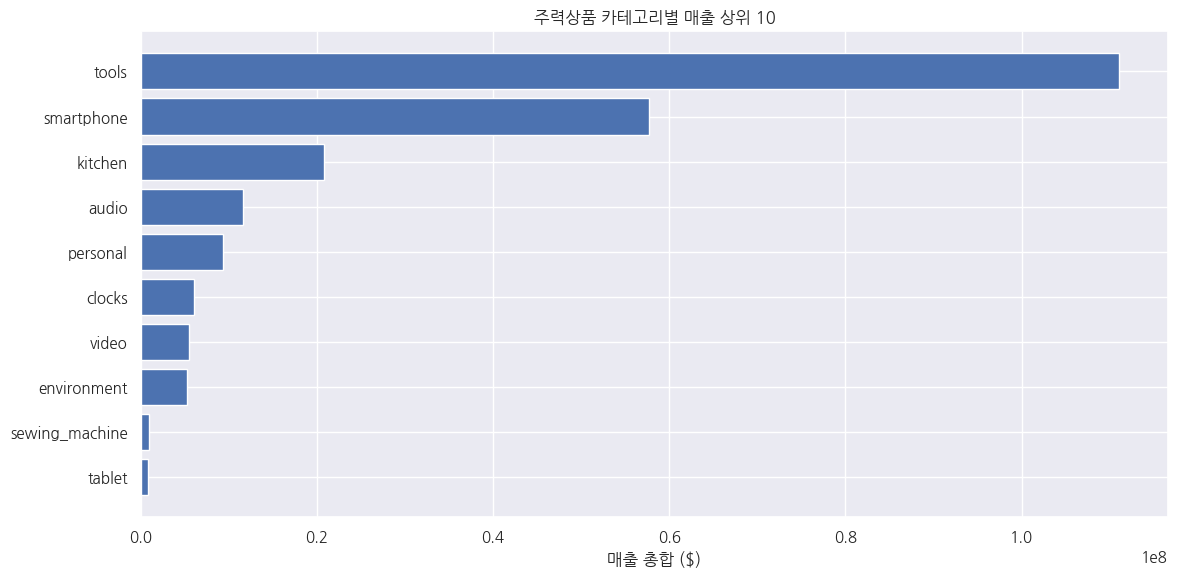

In [60]:
# 4. 카테고리별 매출 총합 (category_lvl2 기준)
category_revenue = purchase_df.groupby('category_lvl2')['price'].sum().reset_index(name='total_revenue')
category_revenue = category_revenue.sort_values(by='total_revenue', ascending=False).head(10)

# 5. 시각화
plt.figure(figsize=(12,6))
plt.barh(category_revenue['category_lvl2'], category_revenue['total_revenue'])
plt.xlabel('매출 총합 ($)')
plt.title('주력상품 카테고리별 매출 상위 10')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

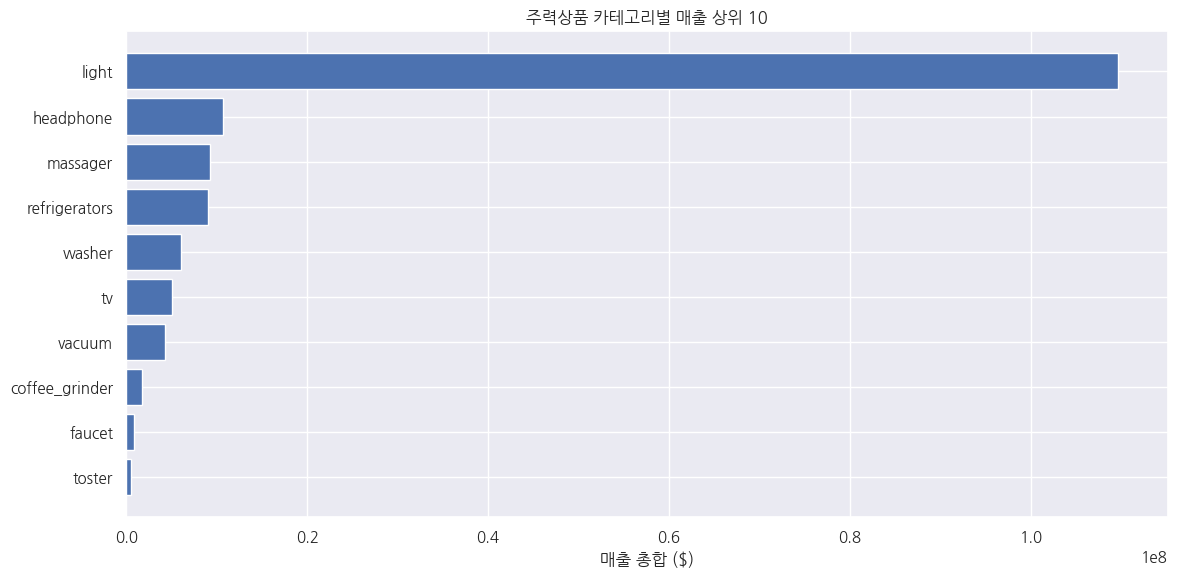

In [61]:
# 4. 카테고리별 매출 총합 (category_lvl3 기준)
category_revenue = purchase_df.groupby('category_lvl3')['price'].sum().reset_index(name='total_revenue')
category_revenue = category_revenue.sort_values(by='total_revenue', ascending=False).head(10)

# 5. 시각화
plt.figure(figsize=(12,6))
plt.barh(category_revenue['category_lvl3'], category_revenue['total_revenue'])
plt.xlabel('매출 총합 ($)')
plt.title('주력상품 카테고리별 매출 상위 10')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

/tmp/ipython-input-65-1349848759.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  purchase_df['full_category'] = (


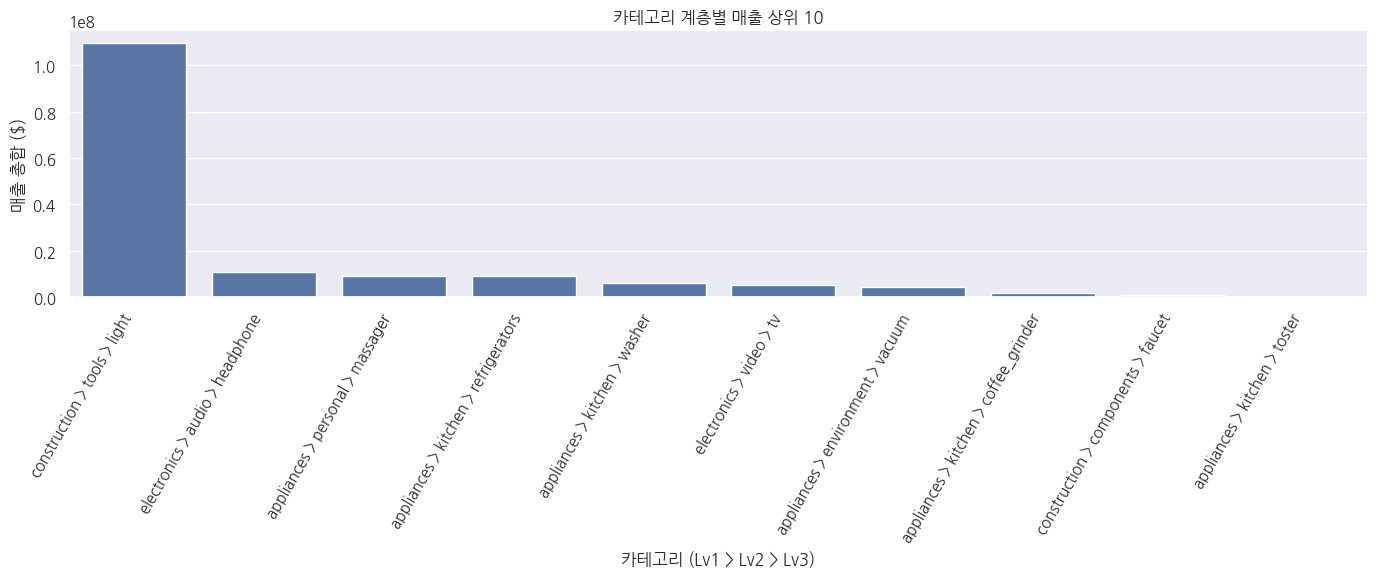

In [65]:
# 1. 계층형 카테고리 컬럼 생성 (category_lvl1 > lvl2 > lvl3)
purchase_df['full_category'] = (
    purchase_df['category_lvl1'] + ' > ' +
    purchase_df['category_lvl2'] + ' > ' +
    purchase_df['category_lvl3']
)

# 2. 카테고리별 매출 총합 계산
category_sales = purchase_df.groupby('full_category')['price'].sum().reset_index(name='total_revenue')

# 3. 매출 상위 10개 항목 추출
top_categories = category_sales.sort_values('total_revenue', ascending=False).head(10)

# 4. 시각화
plt.figure(figsize=(14, 6))
sns.barplot(data=top_categories, x='full_category', y='total_revenue')
plt.xticks(rotation=60, ha='right')
plt.title('카테고리 계층별 매출 상위 10')
plt.xlabel('카테고리 (Lv1 > Lv2 > Lv3)')
plt.ylabel('매출 총합 ($)')
plt.tight_layout()
plt.show()


In [73]:
# construction 하위 데이터 필터링
construction_df = df[df['category_lvl1'] == 'construction']

# category_lvl2 기준 매출 총합
lvl2_revenue = (
    construction_df.groupby('category_lvl2')['price']
    .sum()
    .reset_index(name='total_revenue')
    .sort_values(by='total_revenue', ascending=False)
)

# 상위 2개 category_lvl2 선택
top_lvl2 = lvl2_revenue.head(2)['category_lvl2']

# 해당 데이터 필터링
top_lvl2_df = construction_df[construction_df['category_lvl2'].isin(top_lvl2)]

# category_lvl2, category_lvl3별 매출 합계
lvl3_by_lvl2 = (
    top_lvl2_df.groupby(['category_lvl2', 'category_lvl3'])['price']
    .sum()
    .reset_index(name='category_lvl3_revenue')
)

# 매출 비율 계산
lvl3_by_lvl2['pct_within_lvl2'] = lvl3_by_lvl2['category_lvl3_revenue'] / lvl3_by_lvl2.groupby('category_lvl2')['category_lvl3_revenue'].transform('sum')

# 정렬
lvl3_by_lvl2 = lvl3_by_lvl2.sort_values(['category_lvl2', 'category_lvl3_revenue'], ascending=[True, False])

lvl3_by_lvl2

,category_lvl2,category_lvl3,category_lvl3_revenue,pct_within_lvl2
0,components,faucet,8.122940e+07,1.000000
4,tools,light,3.441495e+09,0.959902
2,tools,drill,5.013866e+07,0.013985
10,tools,welding,3.905951e+07,0.010894
7,tools,saw,2.667023e+07,0.007439
3,tools,generator,1.899442e+07,0.005298
6,tools,pump,3.758092e+06,0.001048
5,tools,painting,2.698764e+06,0.000753
8,tools,screw,1.685685e+06,0.000470
9,tools,soldering,7.460842e+05,0.000208


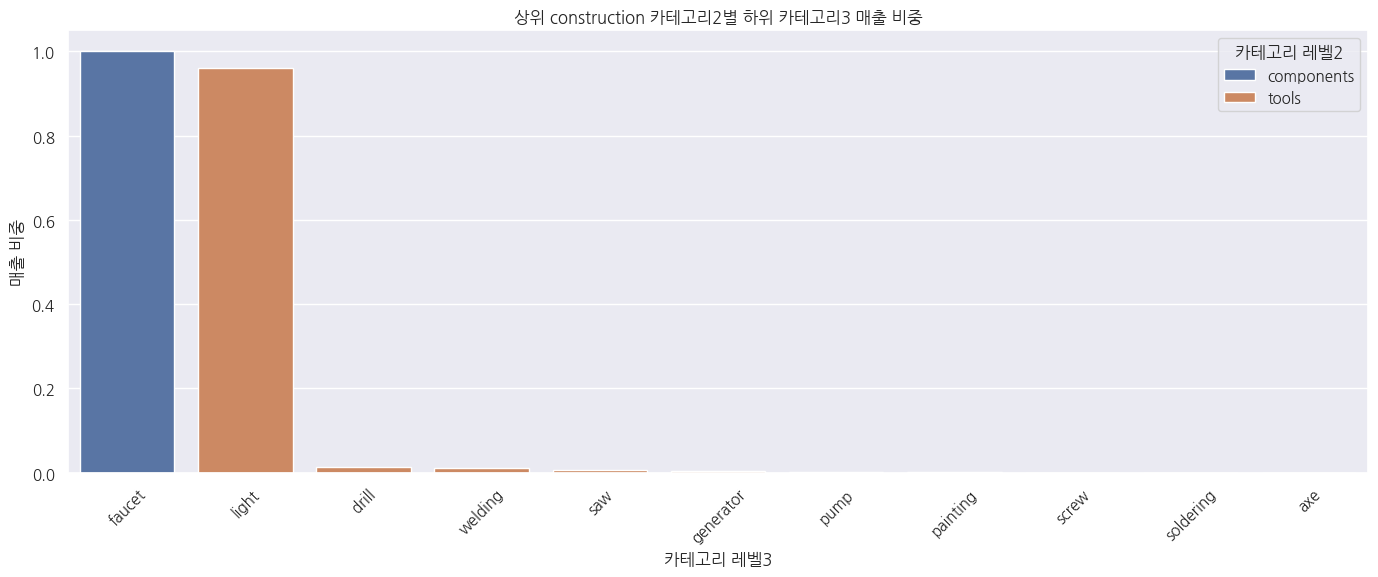

In [74]:
# 시각화 설정
plt.figure(figsize=(14, 6))
sns.barplot(
    data=lvl3_by_lvl2,
    x='category_lvl3',
    y='pct_within_lvl2',
    hue='category_lvl2'
)

plt.title('상위 construction 카테고리2별 하위 카테고리3 매출 비중')
plt.xlabel('카테고리 레벨3')
plt.ylabel('매출 비중')
plt.xticks(rotation=45)
plt.legend(title='카테고리 레벨2')
plt.tight_layout()
plt.show()